A ideia nesse notebook é realizar o processamento dos dados da seguinte maneira:

1. Label dos dados injetados no meio dos normais
2. Criar as features
3. rodar o modelo

# Imports e Definitions

In [ ]:
from google.colab import drive, files

drive.mount('/content/drive')

import pandas as pd
import numpy as np
import operator

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Tue Jan 18 03:30:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+------

Definindo funções essenciais para o Feature Generator

In [ ]:
import gc
from sys import getsizeof

def split_into_nibbles(array):
    array = np.array(array)
    shape = list(array.shape)
    shape[-1] *= 2
    array2 = (array.reshape(-1, 1) & np.array([0xF0, 0x0F], dtype=np.uint8)) >> np.array([4, 0], dtype=np.uint8)
    return array2.reshape(shape)

def create_dataset(dataset, ypsilons, look_back=44, size_bytes=58):
    X, Y = [], []
    look_back += 1

    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back)]
        X.append(a)
        # Y.append(ypsilons.iloc[i+look_back][0]) #verificar se tem pacotes maliciosos
        if np.all(np.array(ypsilons[i:(i+look_back)])== 0):
          Y.append(0)
        else:
          Y.append(1)

    features=[]
    print(len(X))
    for i in range(len(X)):
      deltaX=[]
      e=0
      for e in range(look_back-1):  
        e+=1
        b = split_into_nibbles([((a_i - b_i) % 256) for a_i, b_i in list(zip(X[i][e][:size_bytes], X[i][e-1][:size_bytes]))])       
        deltaX.append(b)
      features.append(np.array(deltaX, dtype=np.uint8))
      if not i % 100000:
        gc.collect()
        print(i)
    print(len(features))
    return np.array(features), np.array(Y)


X, y = create_dataset(np.array(df_X['Data']), df_Y, look_back=44, size_bytes=58)

# 1. Realizando o label dos dados

Carregando dados (Neste notebook fazemos apenas para os dados indoors, usando para treino e validação, a avaliação de teste é feita em outro momento)

In [ ]:
csv_indoor1i = pd.read_csv("/content/drive/MyDrive/Mestrado/automotivas/projeto/csv/indoors_01_injected_converted.csv", 
                           usecols=["pk:number", "data"], dtype={'pk:number': int, 'data': str})
csv_indoor2i = pd.read_csv("/content/drive/MyDrive/Mestrado/automotivas/projeto/csv/indoors_02_injected_converted.csv", 
                           usecols=["pk:number", "data"], dtype={'pk:number': int,'data': str})

csv_attack_msg = pd.read_csv("/content/drive/MyDrive/Mestrado/automotivas/projeto/csv/single-MPEG-frame_converted.csv", 
                           usecols=["pk:number", "data"], dtype={'pk:number': int,'data': str})

Como o dataset está dividido em 2 partes, vamos juntá-los para realizar o processamento

In [ ]:
dataIndoorInject = pd.concat([csv_indoor1i, csv_indoor2i], ignore_index=True)
del csv_indoor1i, csv_indoor2i

Esse comando serve para definir o tipo do dado

In [ ]:
dataIndoorInject.data = dataIndoorInject.data.apply(lambda x: eval(x))
csv_attack_msg.data = csv_attack_msg.data.apply(lambda x: eval(x))

Y_sample_injected é o frame inserido como malicioso dentro do dataset; isso signfica que se algum frame do dataset pertence a "Y_sample_injected"; esse frame tem que ser considerado como malicioso. Nessa etapa, criamos os labels.



In [ ]:
X_train_injected = ((dataIndoorInject.data))
Y_sample_injected = ((csv_attack_msg.data))

In [ ]:
idx_injected = np.array([])
for i in range(Y_sample_injected.shape[0]):
  x = np.where(X_train_injected == Y_sample_injected[i])
  idx_injected = np.concatenate((idx_injected, x[0]), axis=0)

In [ ]:
Y_train_inserted = np.zeros(X_train_injected.shape[0])
for i in idx_injected:
  Y_train_inserted[int(i)] = Y_train_inserted[int(i)] + 1

Nesse ponto tempos os índices onde os maliciosos foram inseridos (lista idx)


In [ ]:
df_Y = pd.DataFrame(Y_train_inserted, columns = ['Data'])
df_X = pd.DataFrame(np.array(X_train_injected), columns = ['Data'])

In [ ]:
df_X

,Data
0,"[91, 207, 30, 86, 71, 64, 65, 48, 7, 80, 9, 16..."
1,"[91, 207, 30, 86, 71, 64, 0, 48, 166, 0, 255, ..."
2,"[91, 207, 30, 86, 71, 0, 65, 18, 255, 253, 105..."
3,"[91, 207, 30, 86, 71, 0, 65, 20, 241, 86, 143,..."
4,"[91, 207, 30, 86, 71, 0, 65, 22, 57, 46, 158, ..."
...,...
643349,"[252, 57, 44, 44, 71, 0, 65, 24, 229, 55, 158,..."
643350,"[252, 57, 44, 44, 71, 0, 65, 26, 204, 46, 243,..."
643351,"[252, 57, 44, 44, 71, 0, 65, 28, 65, 216, 40, ..."
643352,"[252, 57, 44, 44, 71, 0, 65, 30, 24, 127, 255,..."


Aplicando o feature generator


In [ ]:
X, y = create_dataset(np.array(df_X['Data']), df_Y, look_back=44, size_bytes=58)

643309
0
100000
200000
300000
400000
500000
600000
643309


In [ ]:
print(np.unique(y, return_counts=True))

(array([0, 1]), array([168444, 474865]))


Aqui vamos salvar os dados processados para usá-los no futuro sem a necessidade de repetir essas etapas

In [ ]:
from numpy import savez_compressed

savez_compressed('/content/drive/MyDrive/Mestrado/automotivas/projeto/new_aproachs_data/Y_train_NewApproach_Injected_v2.npz', y)
savez_compressed('/content/drive/MyDrive/Mestrado/automotivas/projeto/new_aproachs_data/X_train_NewApproach_Injected_v2.npz', X)

# Load 

(se já fizemos o processamento dos dados previamente, precisamos apenas fazer o load dos dados)

In [ ]:
Y = np.load('/content/drive/MyDrive/Mestrado/automotivas/projeto/new_aproachs_data/Y_train_NewApproach_Injected_v2.npz')
Y= Y.f.arr_0

X = np.load('/content/drive/MyDrive/Mestrado/automotivas/projeto/new_aproachs_data/X_train_NewApproach_Injected_v2.npz')
X = X.f.arr_0

# 2d-Conv

In [ ]:
!pip install scikit-plot &>/dev/null

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, average_precision_score
from scipy.stats import ks_2samp
import scikitplot as skplt

from scipy.stats import ks_2samp
from sklearn.metrics import roc_curve, auc


def extract_final_losses(history):
    """Função para extrair o melhor loss de treino e validação.
    
    Argumento(s):
    history -- Objeto retornado pela função fit do keras.
    
    Retorno:
    Dicionário contendo o melhor loss de treino e de validação baseado 
    no menor loss de validação.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = np.argmin(val_loss)
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(history):
    """Função para plotar as curvas de erro do treinamento da rede neural.
    
    Argumento(s):
    history -- Objeto retornado pela função fit do keras.
    
    Retorno:
    A função gera o gráfico do treino da rede e retorna None.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Error Curves', xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()

def compute_performance_metrics(y, y_pred_class, y_pred_scores=None):
    accuracy = accuracy_score(y, y_pred_class)
    recall = recall_score(y, y_pred_class)
    precision = precision_score(y, y_pred_class)
    f1 = f1_score(y, y_pred_class)
    performance_metrics = (accuracy, recall, precision, f1)
    if y_pred_scores is not None:
        skplt.metrics.plot_ks_statistic(y, y_pred_scores)
        plt.savefig("ks_plot.png")
        plt.show()
        y_pred_scores = y_pred_scores[:, 1]
        auroc = roc_auc_score(y, y_pred_scores)
        aupr = average_precision_score(y, y_pred_scores)
        performance_metrics = performance_metrics + (auroc, aupr)
    return performance_metrics

def print_metrics_summary(accuracy, recall, precision, f1, auroc=None, aupr=None):
    print()
    print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy))
    print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall))
    print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision))
    print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1))
    if auroc is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=auroc))
    if aupr is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUPR:", value=aupr))

In [ ]:
gc.collect()

213

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 44, 116, 32)       832       
                                                                 
 batch_normalization (BatchN  (None, 44, 116, 32)      128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 58, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 58, 64)        51264     
                                                                 
 batch_normalization_1 (Batc  (None, 22, 58, 64)       256       
 hNormalization)                                                 
                                                        

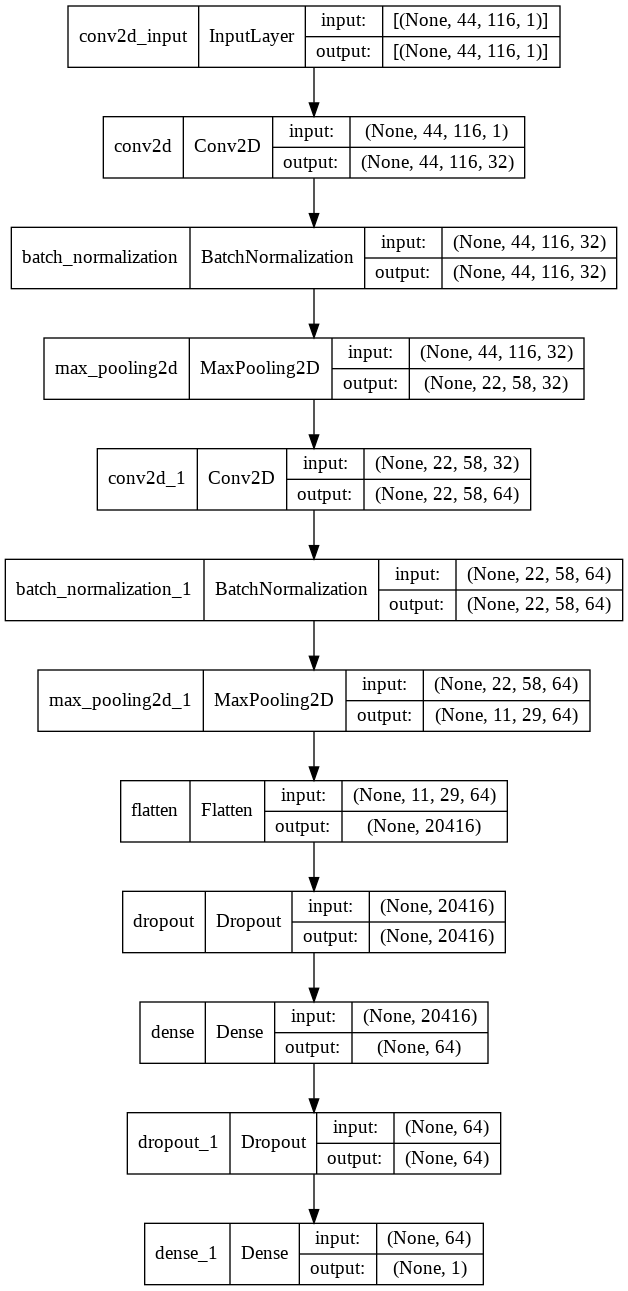

------------------------------------------------------------------------
Epoch 1/30
2011/2011 [==============================] - 63s 31ms/step - loss: 0.2712 - accuracy: 0.9084 - val_loss: 0.0719 - val_accuracy: 0.9826
Epoch 2/30
2011/2011 [==============================] - 62s 31ms/step - loss: 0.0517 - accuracy: 0.9954 - val_loss: 0.0321 - val_accuracy: 0.9973
Epoch 3/30
2011/2011 [==============================] - 62s 31ms/step - loss: 0.0350 - accuracy: 0.9968 - val_loss: 0.0286 - val_accuracy: 0.9959
Epoch 4/30
2011/2011 [==============================] - 61s 31ms/step - loss: 0.0317 - accuracy: 0.9970 - val_loss: 0.0266 - val_accuracy: 0.9972
Epoch 5/30
2011/2011 [==============================] - 62s 31ms/step - loss: 0.0261 - accuracy: 0.9974 - val_loss: 0.0249 - val_accuracy: 0.9978
Epoch 6/30
2011/2011 [==============================] - 62s 31ms/step - loss: 0.0224 - accuracy: 0.9977 - val_loss: 0.0195 - val_accuracy: 0.9982
Epoch 7/30
2011/2011 [=============================

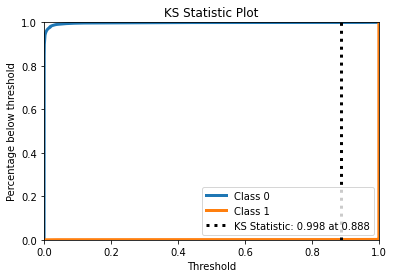

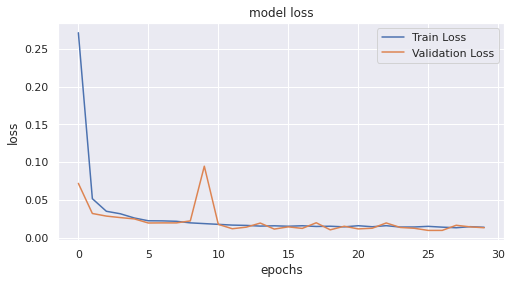

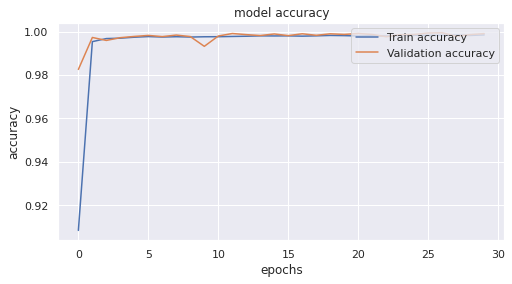

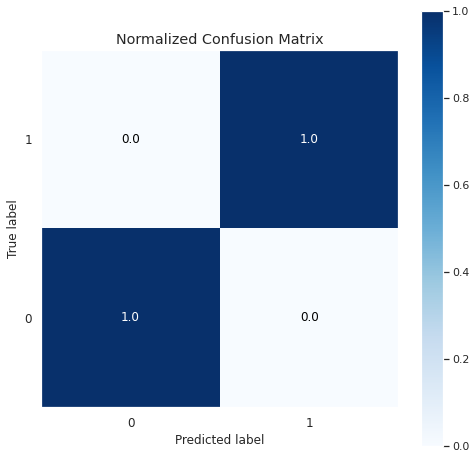

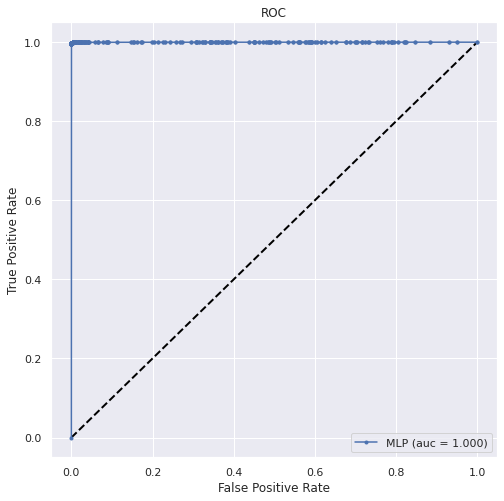

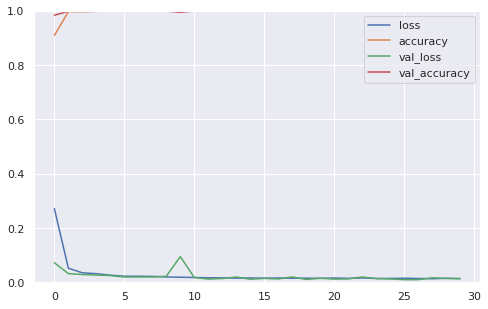

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 44, 116, 32)       832       
                                                                 
 batch_normalization_2 (Batc  (None, 44, 116, 32)      128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 22, 58, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 22, 58, 64)        51264     
                                                                 
 batch_normalization_3 (Batc  (None, 22, 58, 64)       256       
 hNormalization)                                                 
                                                      

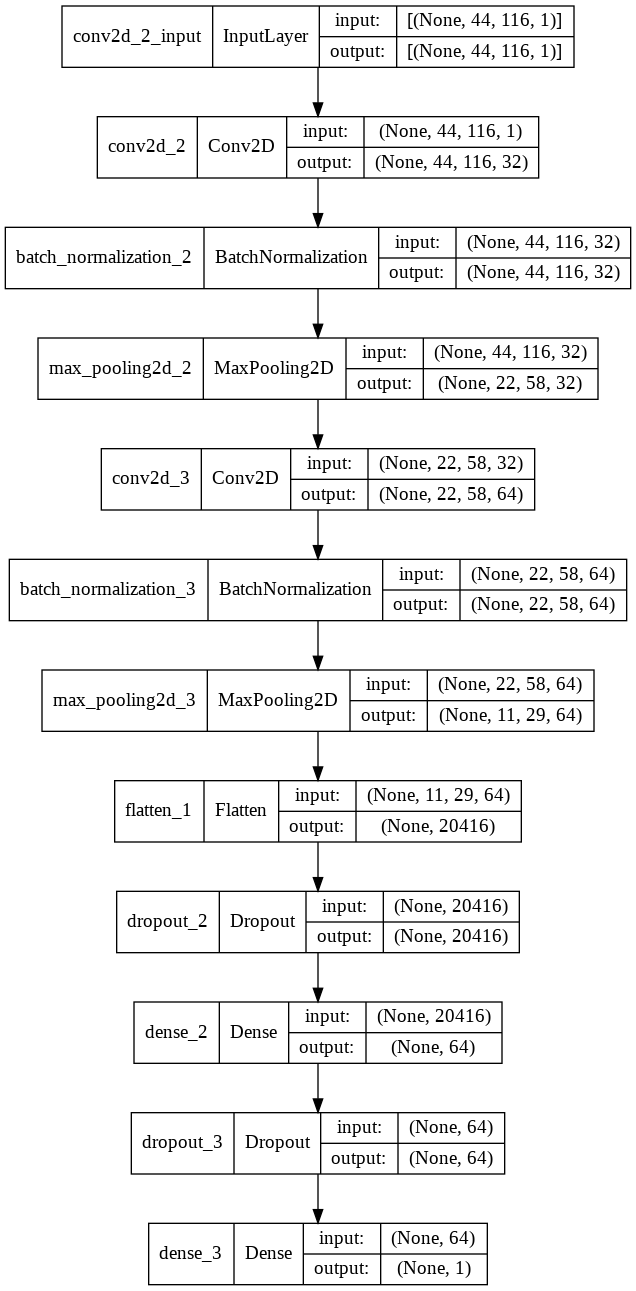

------------------------------------------------------------------------
Epoch 1/30
2011/2011 [==============================] - 63s 31ms/step - loss: 0.6089 - accuracy: 0.7642 - val_loss: 0.4102 - val_accuracy: 0.9834
Epoch 2/30
2011/2011 [==============================] - 62s 31ms/step - loss: 0.2734 - accuracy: 0.9222 - val_loss: 0.1815 - val_accuracy: 0.9956
Epoch 3/30
2011/2011 [==============================] - 62s 31ms/step - loss: 0.2017 - accuracy: 0.9259 - val_loss: 0.1869 - val_accuracy: 0.9606
Epoch 4/30
2011/2011 [==============================] - 62s 31ms/step - loss: 0.1868 - accuracy: 0.9261 - val_loss: 0.2125 - val_accuracy: 0.9679
Epoch 5/30
2011/2011 [==============================] - 62s 31ms/step - loss: 0.1585 - accuracy: 0.9408 - val_loss: 0.1068 - val_accuracy: 0.9810
Epoch 6/30
2011/2011 [==============================] - 62s 31ms/step - loss: 0.0896 - accuracy: 0.9779 - val_loss: 0.6687 - val_accuracy: 0.7473
Epoch 7/30
2011/2011 [=============================

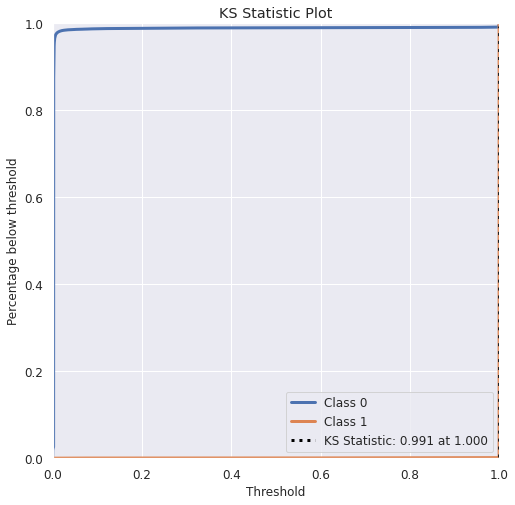

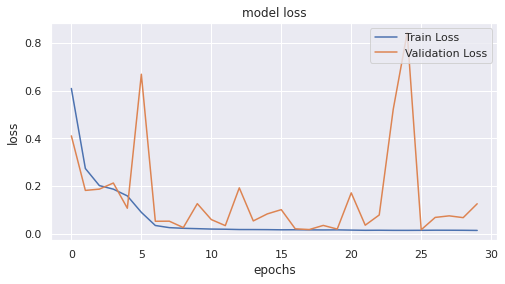

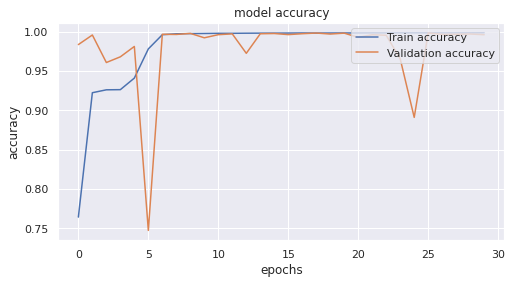

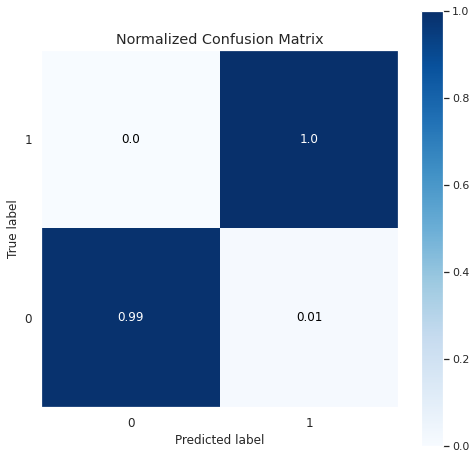

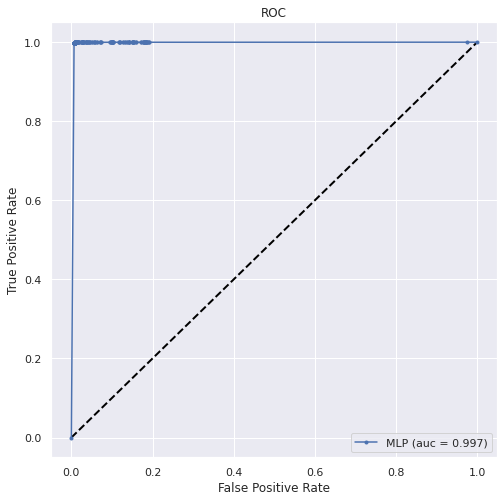

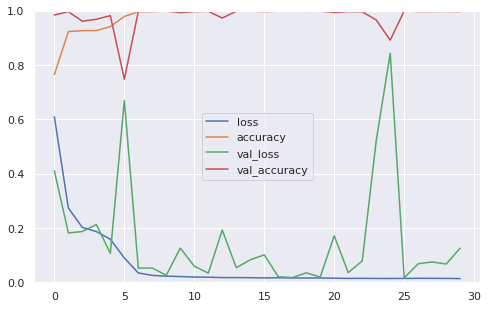

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 44, 116, 32)       832       
                                                                 
 batch_normalization_4 (Batc  (None, 44, 116, 32)      128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 22, 58, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 22, 58, 64)        51264     
                                                                 
 batch_normalization_5 (Batc  (None, 22, 58, 64)       256       
 hNormalization)                                                 
                                                      

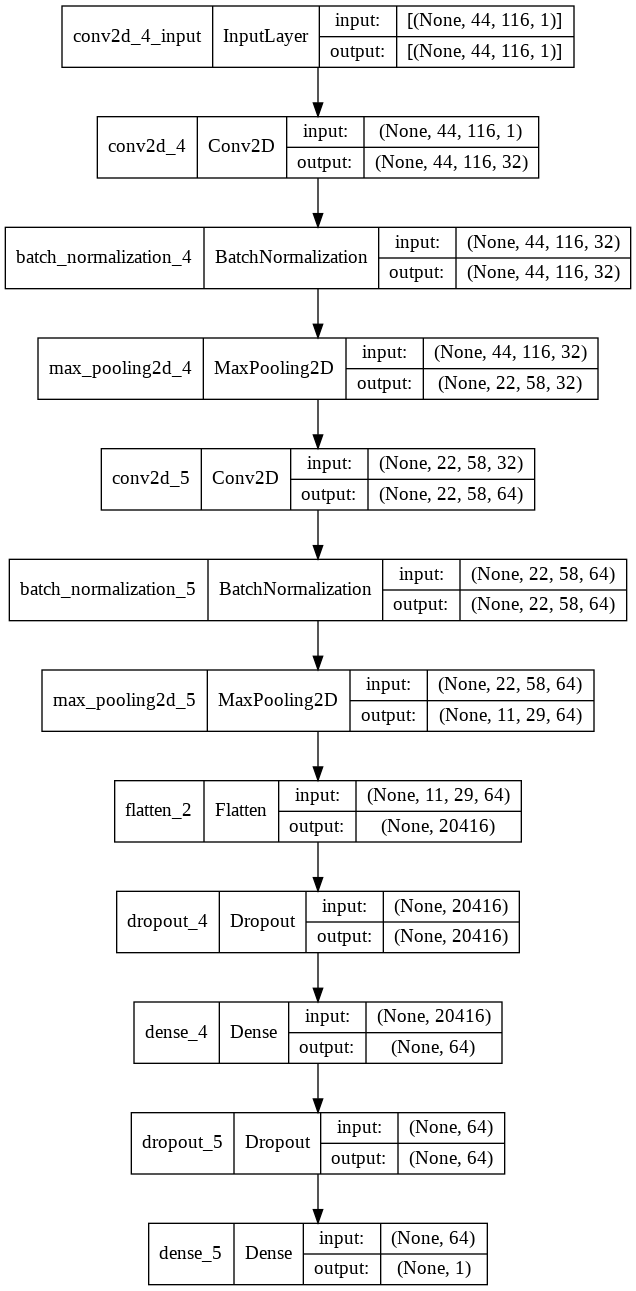

------------------------------------------------------------------------
Epoch 1/30
2011/2011 [==============================] - 63s 31ms/step - loss: 0.7148 - accuracy: 0.7361 - val_loss: 0.5890 - val_accuracy: 0.7406
Epoch 2/30
2011/2011 [==============================] - 62s 31ms/step - loss: 0.3446 - accuracy: 0.9197 - val_loss: 0.0707 - val_accuracy: 0.9956
Epoch 3/30
2011/2011 [==============================] - 62s 31ms/step - loss: 0.0570 - accuracy: 0.9944 - val_loss: 0.1002 - val_accuracy: 0.9846
Epoch 4/30
2011/2011 [==============================] - 62s 31ms/step - loss: 0.0362 - accuracy: 0.9961 - val_loss: 0.0381 - val_accuracy: 0.9933
Epoch 5/30
2011/2011 [==============================] - 62s 31ms/step - loss: 0.0279 - accuracy: 0.9969 - val_loss: 0.0298 - val_accuracy: 0.9972
Epoch 6/30
2011/2011 [==============================] - 62s 31ms/step - loss: 0.0244 - accuracy: 0.9974 - val_loss: 0.0338 - val_accuracy: 0.9955
Epoch 7/30
2011/2011 [=============================

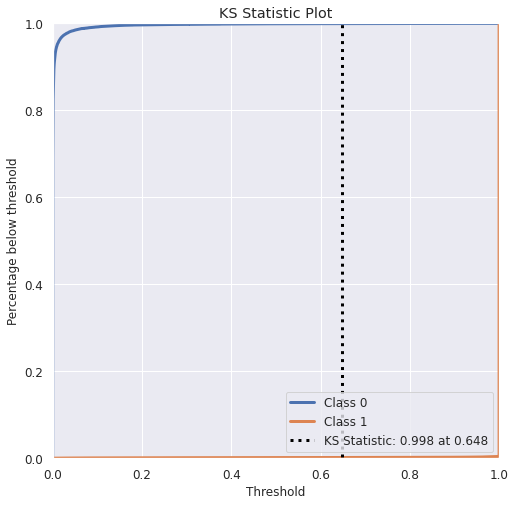

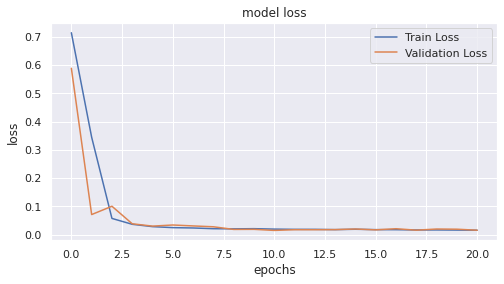

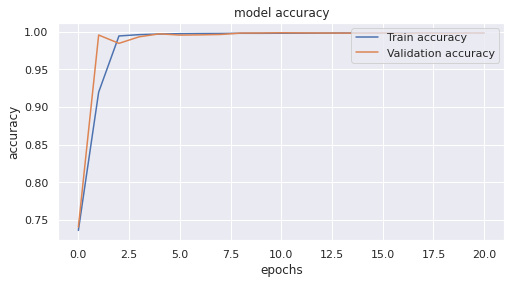

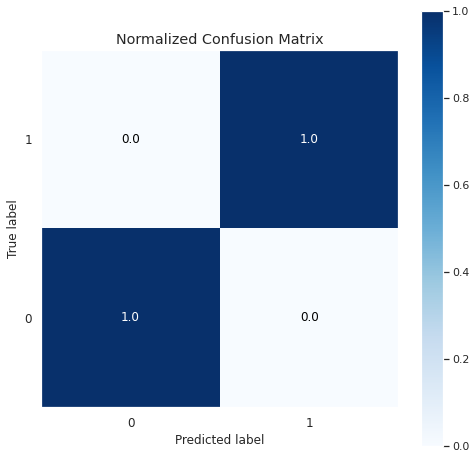

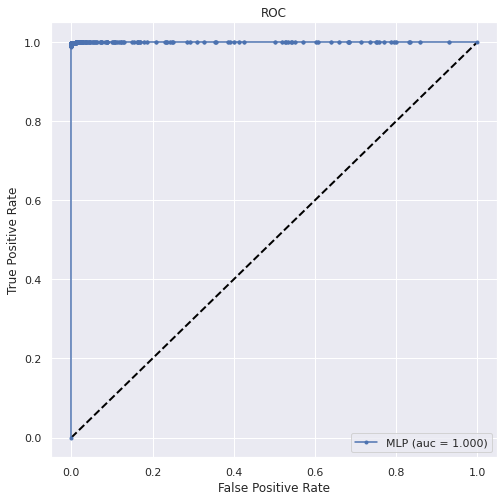

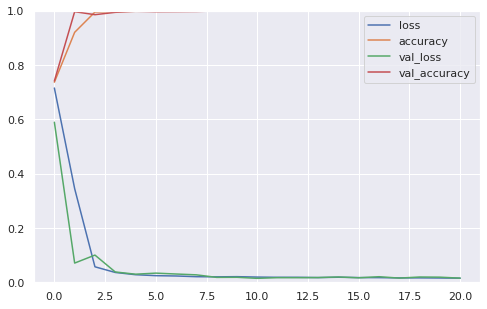

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 44, 116, 32)       832       
                                                                 
 batch_normalization_6 (Batc  (None, 44, 116, 32)      128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 22, 58, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 22, 58, 64)        51264     
                                                                 
 batch_normalization_7 (Batc  (None, 22, 58, 64)       256       
 hNormalization)                                                 
                                                      

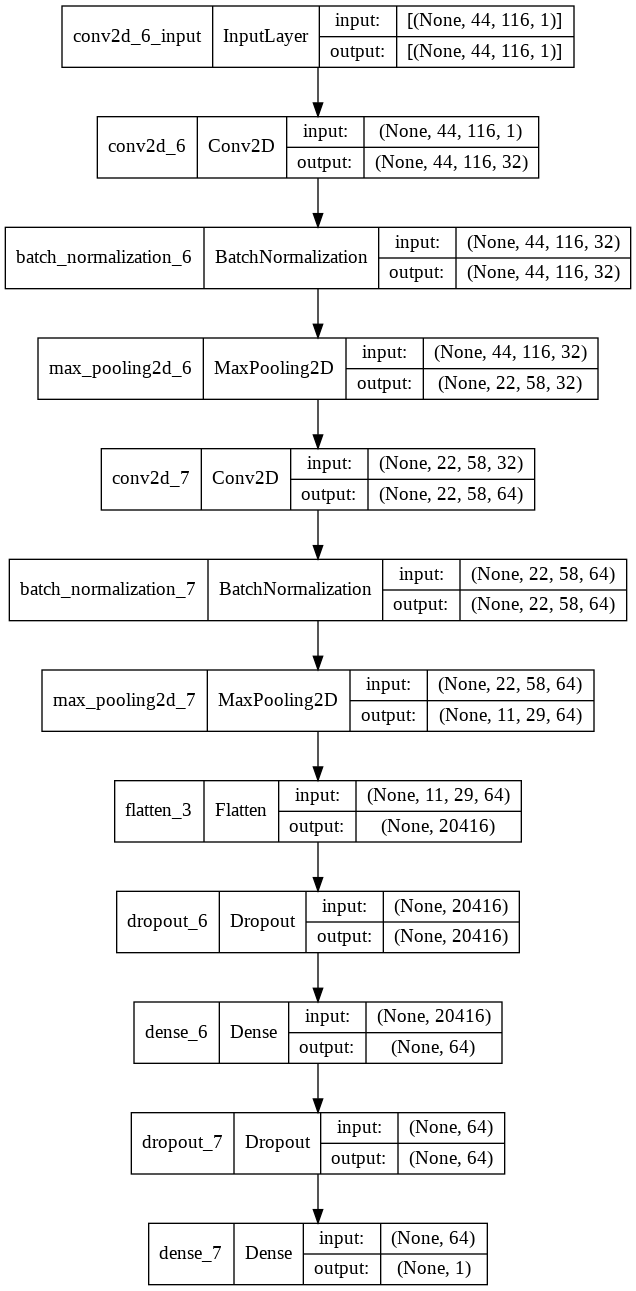

------------------------------------------------------------------------
Epoch 1/30
2011/2011 [==============================] - 63s 31ms/step - loss: 0.1244 - accuracy: 0.9766 - val_loss: 0.0360 - val_accuracy: 0.9977
Epoch 2/30
2011/2011 [==============================] - 62s 31ms/step - loss: 0.0389 - accuracy: 0.9966 - val_loss: 0.0274 - val_accuracy: 0.9985
Epoch 3/30
2011/2011 [==============================] - 62s 31ms/step - loss: 0.0293 - accuracy: 0.9974 - val_loss: 0.0242 - val_accuracy: 0.9980
Epoch 4/30
2011/2011 [==============================] - 62s 31ms/step - loss: 0.0251 - accuracy: 0.9976 - val_loss: 0.0211 - val_accuracy: 0.9985
Epoch 5/30
2011/2011 [==============================] - 62s 31ms/step - loss: 0.0240 - accuracy: 0.9977 - val_loss: 0.0268 - val_accuracy: 0.9964
Epoch 6/30
2011/2011 [==============================] - 62s 31ms/step - loss: 0.0211 - accuracy: 0.9978 - val_loss: 0.0169 - val_accuracy: 0.9990
Epoch 7/30
2011/2011 [=============================

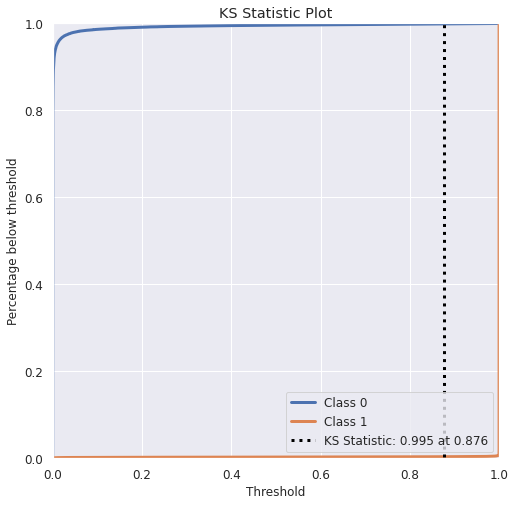

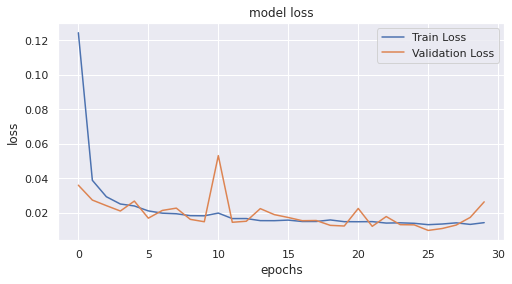

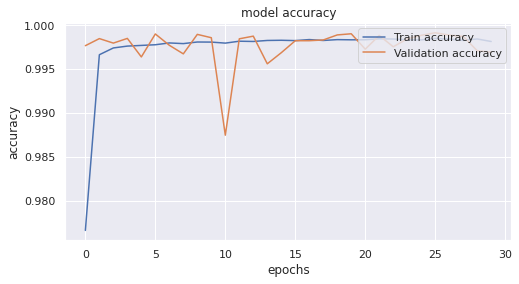

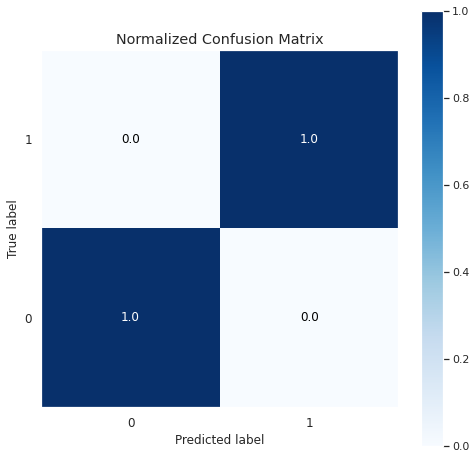

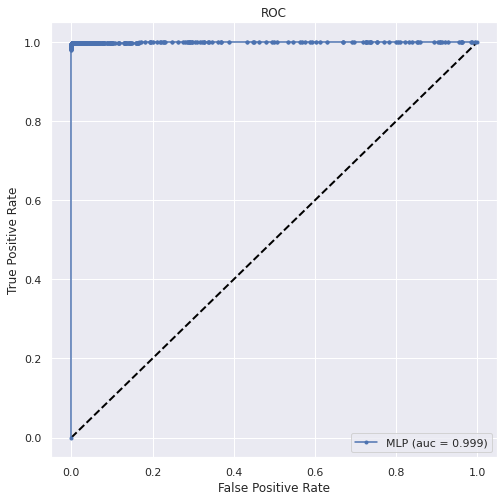

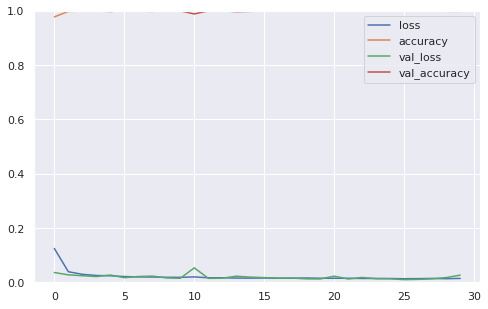

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 44, 116, 32)       832       
                                                                 
 batch_normalization_8 (Batc  (None, 44, 116, 32)      128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 22, 58, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 22, 58, 64)        51264     
                                                                 
 batch_normalization_9 (Batc  (None, 22, 58, 64)       256       
 hNormalization)                                                 
                                                      

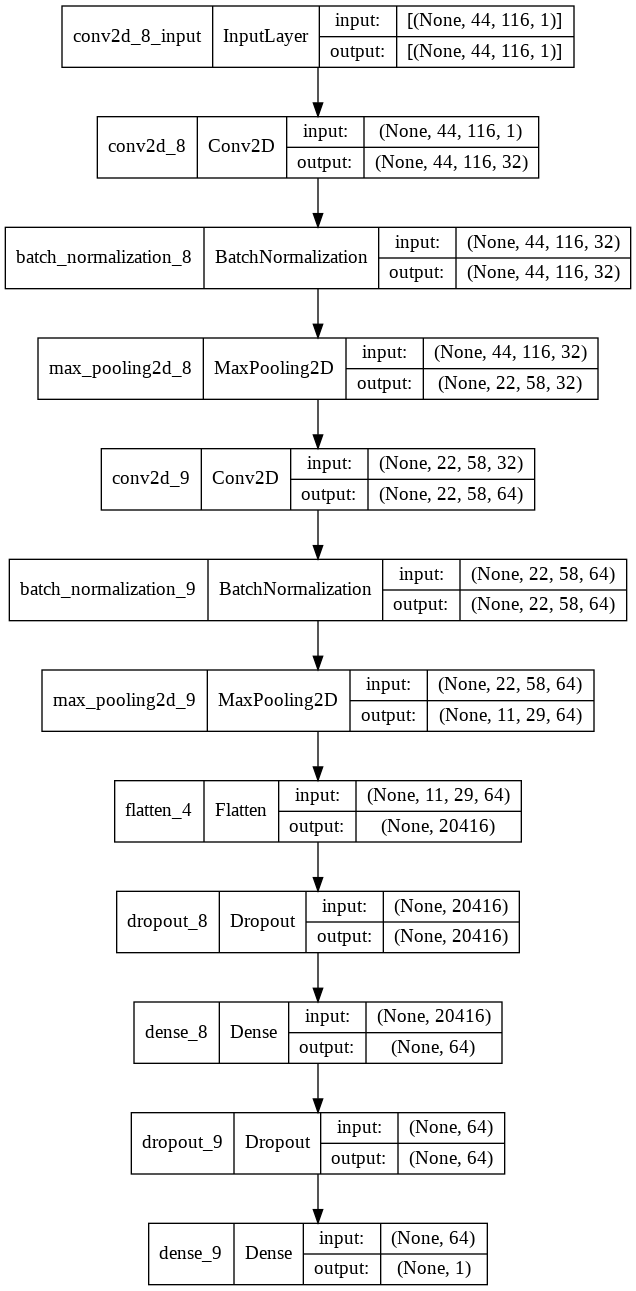

------------------------------------------------------------------------
Epoch 1/30
2011/2011 [==============================] - 63s 31ms/step - loss: 0.7121 - accuracy: 0.7185 - val_loss: 0.5578 - val_accuracy: 0.8500
Epoch 2/30
2011/2011 [==============================] - 62s 31ms/step - loss: 0.2727 - accuracy: 0.9222 - val_loss: 0.0311 - val_accuracy: 0.9978
Epoch 3/30
2011/2011 [==============================] - 62s 31ms/step - loss: 0.0559 - accuracy: 0.9840 - val_loss: 0.0253 - val_accuracy: 0.9982
Epoch 4/30
2011/2011 [==============================] - 62s 31ms/step - loss: 0.0381 - accuracy: 0.9897 - val_loss: 0.0395 - val_accuracy: 0.9945
Epoch 5/30
2011/2011 [==============================] - 62s 31ms/step - loss: 0.0323 - accuracy: 0.9939 - val_loss: 0.0201 - val_accuracy: 0.9988
Epoch 6/30
2011/2011 [==============================] - 62s 31ms/step - loss: 0.0272 - accuracy: 0.9969 - val_loss: 0.0178 - val_accuracy: 0.9983
Epoch 7/30
2011/2011 [=============================

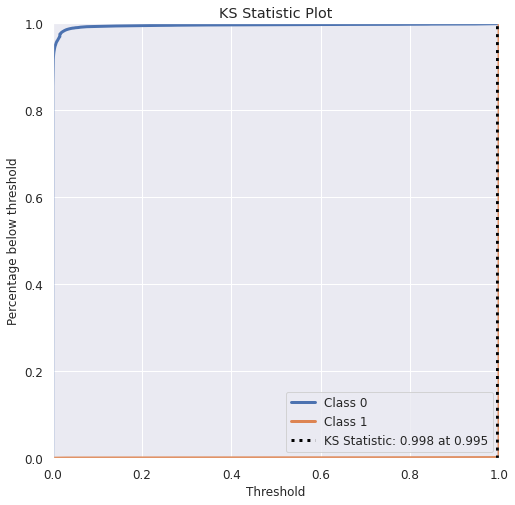

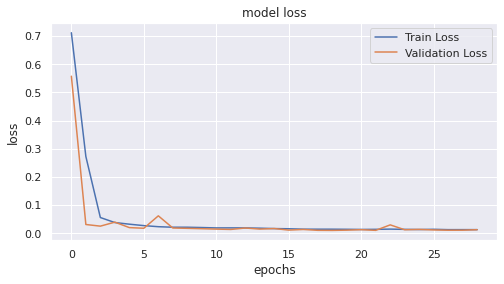

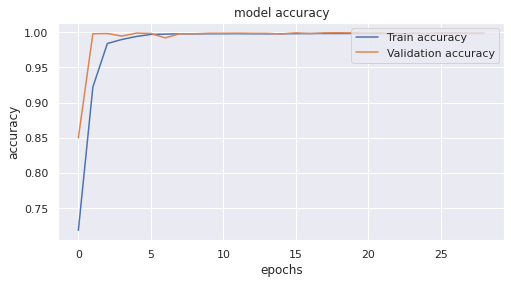

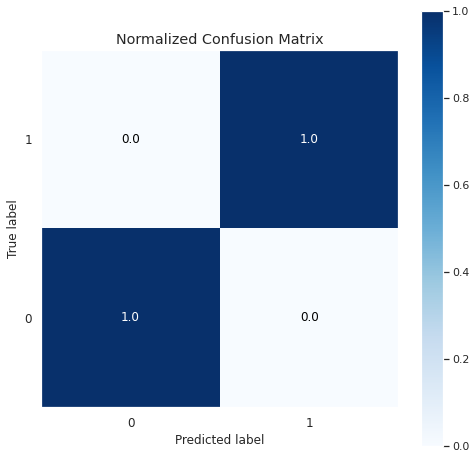

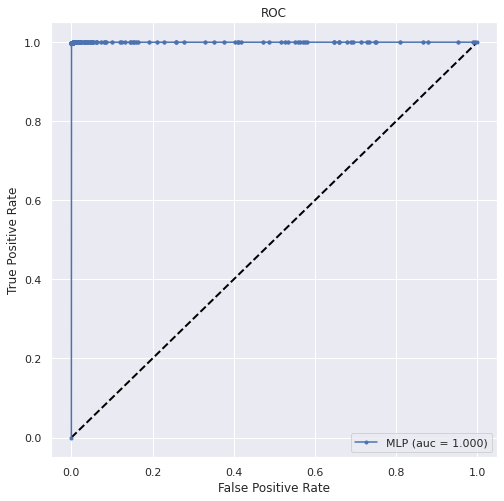

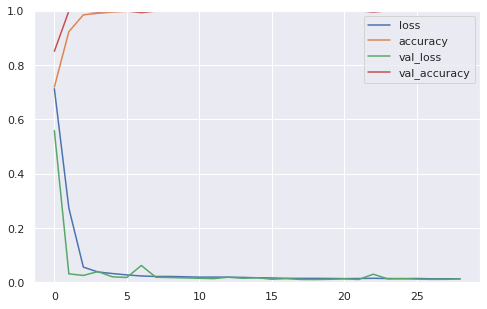

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

import matplotlib.pyplot as plt
import sklearn
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")

keras.backend.clear_session()

# np.random.seed(42)
# tf.random.set_seed(42)

import pandas as pd
from sklearn.metrics import accuracy_score, plot_confusion_matrix, confusion_matrix, classification_report
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.utils.vis_utils import plot_model
from IPython.display import display, Image
import matplotlib.image as mpimg
from sklearn.metrics import mean_squared_error

from tensorflow.keras import regularizers
from sklearn.model_selection import KFold
import gc 
import time
import sys

tmp_path = '/content/drive/MyDrive/Mestrado/automotivas/projeto/new_aproachs_data/results/fold'

#CRIANDO A REDE CONV

skf = KFold(n_splits=5)

fold_no = 0
for train_index, val_index in skf.split(X, Y):
  fold_no += 1
  save_path = tmp_path + str(fold_no) + '/'
  file1 = open(save_path + 'fold' + str(fold_no) + '_log.txt', "a")

  if True:
    x_train, x_val = X[train_index], X[val_index]
    y_train, y_val = Y[train_index], Y[val_index]

    print(f'Train: {np.unique(y_train, return_counts=True)}', file=file1)

    print(f'Val: {np.unique(y_val, return_counts=True)}', file=file1)

    gc.collect()

    model = keras.models.Sequential()
    #1
    model.add(Conv2D(filters=32, kernel_size=5, strides=(1, 1), activation='relu', 
                     kernel_regularizer=regularizers.l2(0.01), padding='same', input_shape=(44, 116, 1)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))

    #2
    model.add(Conv2D(filters=64, kernel_size=5, strides=(1, 1), activation='relu', 
                     kernel_regularizer=regularizers.l2(0.01), padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))

    # #flatten
    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))


    print(model.summary(), file=file1)

    plot_model(model, to_file="conv2d.png", show_shapes=True, show_layer_names=True)
    display(Image(filename='conv2d.png'))


    #
    model.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=["accuracy"])

    # reduz o parâmetro de learning rate se não houver 
    # melhoras em determinado número de epocas
    # útil para encontrar o mínimo global.
    # learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
    #                                             patience=3, 
    #                                             verbose=1, 
    #                                             factor=0.5, 
    #                                             min_lr=0.00001)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...', file=file1)

    #Treinando a Rede Neural definida utilizando 30 épocas
    # history = model.fit(x_train, y_train, epochs=30, validation_data=(x_val, y_val), batch_size=64,
    #                     callbacks=[early_stopping], verbose=1, shuffle=False)
    history = model.fit(x_train, y_train, epochs=30, validation_data=(x_val, y_val), batch_size=256,
                          callbacks=[early_stopping], verbose=1, shuffle=True)
                          #callbacks=[learning_rate_reduction, early_stopping], verbose=1, shuffle=True)

    # Generate generalization metrics
    # scores = model.evaluate(x_val, y_val, verbose=0)
    # y_pred_scores = model.predict(x_val) 
    # y_pred_class=np.argmax(y_pred_scores,axis=1)

    # accuracy, recall, precision, f1, auroc, aupr, ks = compute_performance_metrics(y_val, y_pred_class, y_pred_scores)
    # mseTeste = mean_squared_error(y_val, y_pred_class)

    # print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    
    # print(f'Results for fold {fold_no}: Recall of {recall}; accuracy of {accuracy}; precision of {precision}; f1 of {f1}; auroc of {auroc}; aupr of {aupr}')

    # acc_per_fold.append(scores[1] * 100)
    # loss_per_fold.append(scores[0])

    #########################################################################################################

    y_pred_scores = model.predict(x_val)
    y_pred_class = (y_pred_scores > 0.5).astype("int64")

    y_pred_scores2 = y_pred_scores
    y_pred_scores_0 = 1 - y_pred_scores
    y_pred_scores = np.concatenate([y_pred_scores_0, y_pred_scores], axis=1)

    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_val, y_pred_class, y_pred_scores)
    
    mseTeste = mean_squared_error(y_val, y_pred_class)
    
    print(f'Results for fold {fold_no}: Recall of {recall}; accuracy of {accuracy}; precision of {precision}; f1 of {f1}; auroc of {auroc}; aupr of {aupr}', file=file1)

    sns.set(rc={'figure.figsize':(8,8)})      
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.savefig(save_path + "loss_and_val_loss.png")
    plt.show()

    sns.set(rc={'figure.figsize':(8,8)})      
    plt.figure(figsize=(8,4))
    plt.plot(history.history['accuracy'], label='Train accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.savefig(save_path + "loss_and_val_accuracy.png")
    plt.show()

    sns.set(rc={'figure.figsize':(8,8)})
    subplot = skplt.metrics.plot_confusion_matrix(y_val, y_pred_class, normalize=True)
    subplot.set_ylim(-0.5, 1.5)
    plt.savefig(save_path + "conf_matrix.png")
    plt.show()
      
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_val, y_pred_scores2)
    auc_keras = auc(fpr_keras, tpr_keras)


    sns.set(rc={'figure.figsize':(8,8)})
    plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
    plt.plot(fpr_keras, tpr_keras, marker='.', label='MLP (auc = %0.3f)' % auc_keras)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.savefig(save_path + "plot_roc.png")
    plt.show()
    #########################################################################################################
    #Plotando o histórico do treino
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

    model_name = 'fold_n_' + str(fold_no) + '_2dconv_fixed.h5'
    model.save(save_path + model_name)

    file1.close()

    del x_train
    gc.collect()
    del y_train
    gc.collect()
    del x_val
    gc.collect()
    del y_val

    gc.collect()
    time.sleep(5)
    gc.collect()
  else:
    pass
